<a href="https://colab.research.google.com/github/QuangMinhPhan23/emotions-classification-for-tweets/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>1. Introduction, Motivation and Problem Statement </div></b>

Classification, which process massive inputs to required classes is one of the fundamental task in machine learning. In this project, we will build the LSTM model and then evaluate it to read English text from users in Tweet and classify the into six basic emotions:

`sadness`, `joy`, `love`, `anger`, `fear`, or `surprise`.

The task is important and have media applications such as:

- Enhancing conversational agents
- System recommendation based on emotion
- Sentiment monitoring on social media

This project is run on Google Colab, parameters are adjusted to fit the memory of Google Colab.

In [ ]:
!pip install -U datasets huggingface_hub fsspec
!pip install tensorflow==2.8.0


  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)
ERROR: Could not find a version that satisfies the requirement tensorflow==2.8.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.8.0


# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'> The dataset </div></b>


We use the **[`dair‑ai/emotion`](https://huggingface.co/datasets/dair-ai/emotion)** dataset on HuggingFace, which contains around 20,000 English text samples labelled with one of six emotions. The dataset is split into training, validation, and test subsets. Each sample is a short text message (tweet) with a single emotion label.

Below, we download and explore the dataset.


In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import Input, concatenate, SpatialDropout1D
from tensorflow.keras.models import Model

nltk.download('omw-1.4')  # Download the OMW data
nltk.download('wordnet')   # Also ensure WordNet is downloaded
nltk.download('punkt')     # Needed for tokenization
nltk.download('stopwords')


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
data = load_dataset("dair-ai/emotion", "split")
data.save_to_disk("./data")
#df = pd.read_csv('data.csv')


train_data = data['train']
train = train_data.to_pandas()

test_data = data['test']

print(data.column_names)

Saving the dataset (0/1 shards):   0%|          | 0/16000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

{'train': ['text', 'label'], 'validation': ['text', 'label'], 'test': ['text', 'label']}


### Data Preprocessing

  - Tokenization using Keras’s tokenizer
  - Truncation to model max length equal 50

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import SpatialDropout1D, Embedding, BatchNormalization, SpatialDropout1D, LSTM, Bidirectional, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(data):
    text = data['text']
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from hashtags
    text = re.sub(r'\@\w+|\#', '', text)
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Convert to lowercase
    text = text.lower()
    # Lemmatization and remove stopwords
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return {'cleaned_text': text}

data['cleaned_text'] = data.map(clean_text)

# Max length is 66

tokenizer = Tokenizer() #Keras Tokenizer
tokenizer.fit_on_texts(data['train']['text'])
MAX_LEN = 50

def tokenize_text(example):
    sequences = tokenizer.texts_to_sequences([example['text']])  # Note the list wrapping
    padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
    return {'input_ids': padded[0]}  # Return first (and only) sequence

# Apply to dataset
for split in data.keys():
    data[split] = data[split].map(tokenize_text)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Prepare Class Weights to handle imbalanced data in training


In [ ]:
# Handle imbalanced data
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disables GPU
from sklearn.utils.class_weight import compute_class_weight

# Assuming your data is in a pandas DataFrame called 'data'
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']  # Raw emotion labels (e.g., 'joy', 'sadness')

# Convert string labels to numerical indices if needed
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels_numeric = label_encoder.fit_transform(labels)  # e.g., 'joy' → 0, 'sadness' → 1, etc.

# Compute class weights
# Check class distribution
labels = np.array(data['train']['label'])
class_counts = np.unique(labels, return_counts=True)
print("Class distribution:", class_counts)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class distribution: (array([0, 1, 2, 3, 4, 5]), array([4666, 5362, 1304, 2159, 1937,  572]))
Class weights: {0: np.float64(0.5715102157451064), 1: np.float64(0.49732686808404825), 2: np.float64(2.044989775051125), 3: np.float64(1.2351397251814111), 4: np.float64(1.3766993632765445), 5: np.float64(4.662004662004662)}


### Prepare to use Glove Embedding
- Embedding Tokens to dense vectors 300 dimensions using Glove.
- Prepare the Pre-trained Embedding matrix from https://nlp.stanford.edu/projects/glove/

In [ ]:
#Use Glove to embedding Tokens to dense vectors 300 dimensions

max_length = 50  # Set based on your sequence analysis
EMBEDDING_DIM = 300  # GloVe embedding dimension
num_classes = 6  # For your 6 emotion classes
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token (0)
print("Vocabulary size:", vocab_size)

# Prepare the embedding matrix for glove

def load_glove_embeddings(glove_path, embedding_dim):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():  # Skip empty lines
                    values = line.split()
                    if len(values) > 1:  # Ensure valid line
                        word = values[0]
                        coefs = np.asarray(values[1:], dtype='float32')
                        embeddings_index[word] = coefs
    #except FileNotFoundError:
       # print(f"Error: File {glove_path} not found! Download it first.")
    return embeddings_index

glove_embeddings = load_glove_embeddings('glove.6B.300d.txt', 300)

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < vocab_size+1:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print(embedding_matrix[2560:2565])

Vocabulary size: 15213
[[-0.37632    -0.083171   -0.54272997 ...  0.40400001  0.10301
   0.3619    ]
 [ 0.0074537   0.34031001  0.22861999 ...  0.024352   -0.17038
  -0.13253   ]
 [-0.60302001 -0.044943    0.13086    ...  0.1286     -0.32820001
   0.046796  ]
 [-0.13488001  0.04698    -0.068877   ... -0.49518999  0.27897
  -0.10379   ]
 [-0.35960001  0.42245001 -0.31964999 ... -0.68923002 -0.59885001
  -0.29800999]]


# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>4. Model and Methods </div></b>

We use the 2-layers LSTM model for this emotion classification task.

### Methodology:
- Model Architecture:
  - An embedding layer
  - A biLSTM layer with kernel regulizer l2(0.01)
  - Another biLSTM layer with kernel regulizer
  - A Fully Connected output layer
  - Use Spatial Drop out rate =0.3 to reduce overfitting
  - Use BatchNormalization to escape local minima in training

- Optimization:
  - Optimizer: Adam (`learning_rate=1e‑3`)
  - Batch size: 32
  - Epochs: 10
  - Early Stopping (stop at epoch 7)
- Evaluation:
  - During training using CategoricalCrossentropy function from Keras with probability output
  - Metrics: accuracy, precision, recall, f1‑score (per class), confusion matrix



In [ ]:
# Build and train the LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D, Embedding, BatchNormalization, SpatialDropout1D, LSTM, Bidirectional, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=MAX_LEN, trainable=True),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01))),
    BatchNormalization(),  # Helps escape local minima
    Bidirectional(LSTM(64, kernel_regularizer=l2(0.01))),
    Dense(6, activation='softmax')
    ])
# Train the model

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc', multi_label=True)
        ]
    )

def prepare_test_data(test_data):
    # Convert to numpy arrays
    X_test = np.array(test_data['input_ids'])  # Using already tokenized input_ids
    y_test = np.array(test_data['label'])  # Original labels

    # One-hot encode labels
    y_test = to_categorical(y_test, num_classes=num_classes)

    return X_test, y_test

X_train, y_train = prepare_test_data(data['train'])
X_val, y_val = prepare_test_data(data['validation'])
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=3,            # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore model weights from the epoch with best val_loss
    verbose=1              # Show messages when stopping
)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32, class_weight=class_weights, callbacks=[early_stopping], verbose=1)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 368s 718ms/step - accuracy: 0.2468 - auc: 0.6371 - loss: 6.3682 - precision: 0.3399 - recall: 0.0270 - val_accuracy: 0.5530 - val_auc: 0.9500 - val_loss: 1.4035 - val_precision: 0.5922 - val_recall: 0.4270
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 391s 736ms/step - accuracy: 0.8092 - auc: 0.9721 - loss: 0.8833 - precision: 0.8405 - recall: 0.7685 - val_accuracy: 0.8900 - val_auc: 0.9901 - val_loss: 0.6037 - val_precision: 0.9203 - val_recall: 0.8545
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 349s 697ms/step - accuracy: 0.9022 - auc: 0.9899 - loss: 0.5239 - precision: 0.9140 - recall: 0.8925 - val_accuracy: 0.9160 - val_auc: 0.9945 - val_loss: 0.4670 - val_precision: 0.9258 - val_recall: 0.9105
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 370s 674ms/step - accuracy: 0.9245 - auc: 0.9938 - loss: 0.3937 - precision: 0.9304 - recall: 0.9193 - val_accuracy: 0.9285 - val_auc: 0.9965 - val_loss: 0.3527 - val_precision: 0.9306 - val_recall: 0.9255
Epoch 5/10
500/5

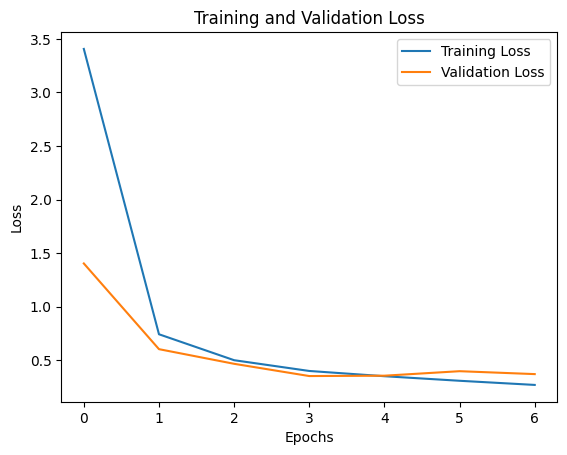

In [ ]:

# Plotting training and validation loss
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



Test Metrics:
Loss: 0.3854
Accuracy: 0.9155
Precision: 0.9184
Recall: 0.9115
AUC: 0.9951
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step

Classification Report:
              precision    recall  f1-score   support

     sadness       1.00      0.92      0.96       581
         joy       0.98      0.90      0.94       695
        love       0.75      0.95      0.84       159
       anger       0.89      0.95      0.92       275
        fear       0.85      0.85      0.85       224
    surprise       0.60      1.00      0.75        66

    accuracy                           0.92      2000
   macro avg       0.85      0.93      0.88      2000
weighted avg       0.93      0.92      0.92      2000

[[536   2   0  25  13   5]
 [  0 627  50   0   6  12]
 [  0   8 151   0   0   0]
 [  0   1   0 260  14   0]
 [  0   0   0   6 191  27]
 [  0   0   0   0   0  66]]


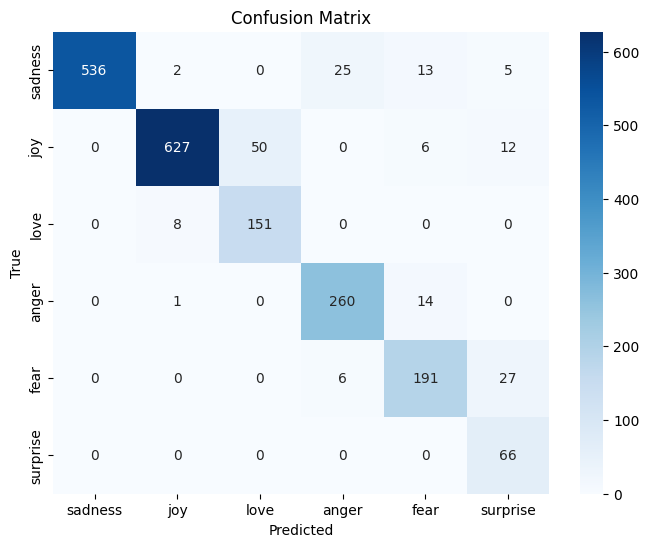


Test Metrics:
Loss: 0.3854
Accuracy: 0.9155
Precision: 0.9184
Recall: 0.9115
AUC: 0.9951
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step

Classification Report:
              precision    recall  f1-score   support

     sadness       1.00      0.92      0.96       581
         joy       0.98      0.90      0.94       695
        love       0.75      0.95      0.84       159
       anger       0.89      0.95      0.92       275
        fear       0.85      0.85      0.85       224
    surprise       0.60      1.00      0.75        66

    accuracy                           0.92      2000
   macro avg       0.85      0.93      0.88      2000
weighted avg       0.93      0.92      0.92      2000

[[536   2   0  25  13   5]
 [  0 627  50   0   6  12]
 [  0   8 151   0   0   0]
 [  0   1   0 260  14   0]
 [  0   0   0   6 191  27]
 [  0   0   0   0   0  66]]


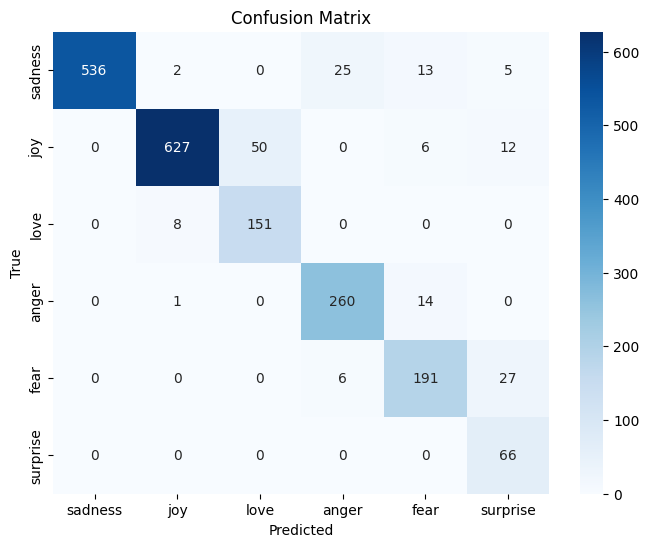

In [ ]:
# Evaluate the performance

# Prepare test data
X_test, y_test = prepare_test_data(data['test'])

# Evaluate model performance
def evaluate_model(model, X_test, y_test):
    # Evaluate metrics
    loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test, verbose=0)

    print("\nTest Metrics:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC: {auc:.4f}")

    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_classes,
                              target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']))

    # Confusion matrix
    np.save('y_true.npy', y_test_classes)
    np.save('y_pred.npy', y_pred)
    y_true = np.load('y_true.npy')
    y_pred = np.load('y_pred.npy')
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    print(cm)
    labels_names = data['train'].features['label'].names  # ['sadness', 'joy', ..., 'anger']

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_names, yticklabels=labels_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


    return y_pred

# Run evaluation
y_pred = evaluate_model(model, X_test, y_test)

# Run evaluation
y_pred = evaluate_model(model, X_test, y_test)